# Problem ciągły: 4-kryterialny, 2-wymiarowy (N=4, U ∈ ℝ²)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

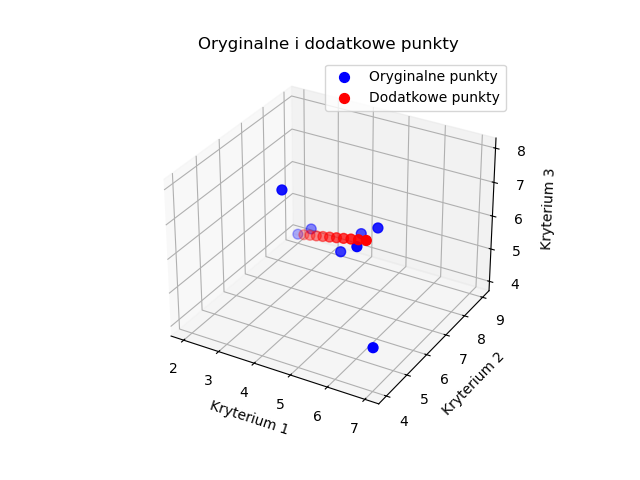

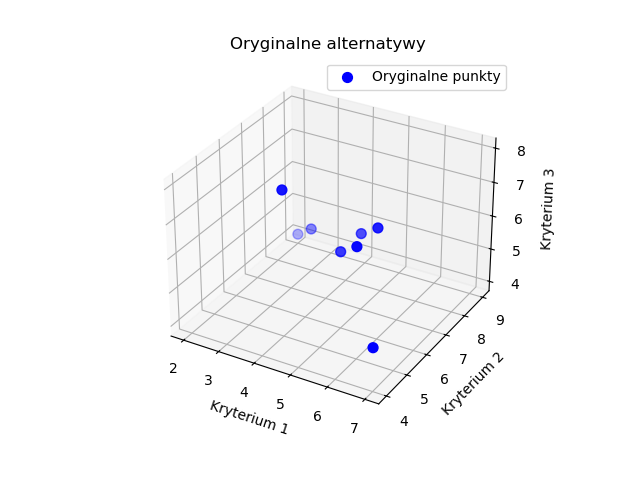

In [3]:
%matplotlib widget


# Dane wejściowe
alternatives = np.array([
    [5, 7, 6],
    [3, 8, 5],
    [6, 6, 7],
    [2, 9, 4],
    [4, 5, 8],
    [7, 4, 5],
    [5, 6, 6],
    [6, 5, 7]
])

directions = np.array([-1, 1, -1])
a = np.array([2, 9, 4])
b = np.array([7, 4, 8])

def continuous_reference_set_method(alternatives, directions, a, b, n_extra=10):
    M = alternatives.shape[1]
    # Generowanie punktów wzdłuż linii łączącej a i b
    extra_points = np.zeros((n_extra, M))
    for i in range(n_extra):
        t = (i+1)/(n_extra+1)
        extra_points[i, :] = a + t*(b - a)
    
    all_points = np.vstack([alternatives, extra_points])

    def normalize(points, a, b, directions):
        norm_alt = np.zeros_like(points, dtype=float)
        for i in range(len(directions)):
            if directions[i] == -1:  # Minimalizacja
                norm_alt[:, i] = (points[:, i] - a[i]) / (b[i] - a[i])
            else:  # Maksymalizacja
                norm_alt[:, i] = (b[i] - points[:, i]) / (b[i] - a[i])
        return norm_alt

    def scoring_function(points, a, b, directions):
        norm_alt = normalize(points, a, b, directions)
        distance_to_a = np.linalg.norm(norm_alt, axis=1)
        distance_to_b = np.linalg.norm(norm_alt - 1, axis=1)
        C = distance_to_b / (distance_to_a + distance_to_b)
        return C

    scores = scoring_function(all_points, a, b, directions)
    ranking = np.argsort(-scores)

    return ranking, scores, all_points

ranking, scores, all_points = continuous_reference_set_method(alternatives, directions, a, b, n_extra=10)

# Tworzenie wykresów
plt.ion()  # Włączenie interaktywności matplotlib (jeśli backend obsługuje)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(alternatives[:,0], alternatives[:,1], alternatives[:,2], color='blue', s=50, label='Oryginalne punkty')
ax1.set_xlabel('Kryterium 1')
ax1.set_ylabel('Kryterium 2')
ax1.set_zlabel('Kryterium 3')
ax1.set_title('Oryginalne alternatywy')
ax1.legend()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
n_original = len(alternatives)
original_points = all_points[:n_original]
extra_points = all_points[n_original:]
ax2.scatter(original_points[:,0], original_points[:,1], original_points[:,2], color='blue', s=50, label='Oryginalne punkty')
ax2.scatter(extra_points[:,0], extra_points[:,1], extra_points[:,2], color='red', s=50, label='Dodatkowe punkty')
ax2.set_xlabel('Kryterium 1')
ax2.set_ylabel('Kryterium 2')
ax2.set_zlabel('Kryterium 3')
ax2.set_title('Oryginalne i dodatkowe punkty')
ax2.legend()

plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Definicja funkcji celu
def f1(x):
    return x[0]**2 + (x[1]+0.2)**2

def f2(x):
    return (x[0]-1)**2 + (x[1]+1)**2

def f3(x):
    return (x[0] - 3)**2 + (x[1] + 3)**2

def f4(x):
    return (x[0] - 2)**2 + (x[1] - 1)**2

# Funkcja agregująca wartości funkcji celu
def F(x):
    return np.array([f1(x), f2(x), f3(x), f4(x)])

# Kierunek optymalizacji dla każdego kryterium: 1 - maksymalizacja, -1 - minimalizacja
# W tym przykładzie przyjmijmy, że:
# - Kryteria f1 i f3 są do minimalizacji
# - Kryteria f2 i f4 są do maksymalizacji
directions = np.array([-1, 1, -1, 1])  # np. [-1, 1, -1, 1]

# Punkty odniesienia
# Dla kryteriów maksymalizowanych punkt aspiracji to maksymalne wartości
# Dla kryteriów minimalizowanych punkt aspiracji to minimalne wartości
# Dla uproszczenia przyjmijmy, że wartości funkcji celu zawierają się w przedziale [0, 25]
a = np.array([0, 25, 0, 25])  # Punkt aspiracji
b = np.array([25, 0, 25, 0])  # Punkt status quo

# Funkcja normalizująca z uwzględnieniem kierunku optymalizacji
def normalize(f_values, a, b, directions):
    norm_values = np.zeros_like(f_values)
    for i in range(len(f_values)):
        if directions[i] == -1:  # Minimalizacja
            norm_values[i] = (f_values[i] - a[i]) / (b[i] - a[i])
        else:  # Maksymalizacja
            norm_values[i] = (b[i] - f_values[i]) / (b[i] - a[i])
    return norm_values

# Funkcja skoringowa oparta na metodzie TOPSIS
def scoring_function(x, a, b, directions):
    f_values = F(x)
    # Normalizacja z uwzględnieniem kierunku optymalizacji
    f_norm = normalize(f_values, a, b, directions)
    # Obliczanie odległości od punktu idealnego (aspiracji) i anty-idealnego (status quo)
    distance_to_a = np.linalg.norm(f_norm - np.zeros(len(f_norm)))
    distance_to_b = np.linalg.norm(f_norm - np.ones(len(f_norm)))
    # Wskaźnik bliskości do ideału
    C = distance_to_b / (distance_to_a + distance_to_b)
    return C

# Funkcja do minimalizacji (negacja wskaźnika C)
def objective(x):
    return -scoring_function(x, a, b, directions)

# Ograniczenia zmiennych decyzyjnych
bounds = [(-5, 10), (-5, 10)]

# Optymalizacja
result = minimize(
    objective,
    x0=np.array([0.0, 0.0]),  # Punkt startowy
    bounds=bounds,
    method='SLSQP'
)

optimal_x = result.x
optimal_f_values = F(optimal_x)
optimal_score = scoring_function(optimal_x, a, b, directions)

print("Optymalne rozwiązanie:")
print(f"x = [{optimal_x[0]:.4f}, {optimal_x[1]:.4f}]")
print("Wartości funkcji celu:")
for i, f_val in enumerate(optimal_f_values):
    print(f"f{i+1}(x) = {f_val:.4f} {'(min)' if directions[i]==-1 else '(max)'}")
print(f"Wartość funkcji skoringowej: {optimal_score:.4f}")

Optymalne rozwiązanie:
x = [1.7624, -0.9765]
Wartości funkcji celu:
f1(x) = 3.7091 (min)
f2(x) = 0.5818 (max)
f3(x) = 5.6260 (min)
f4(x) = 3.9631 (max)
Wartość funkcji skoringowej: 0.8464


# Problem Dyskretny: 3-Kryterialny

In [14]:
import numpy as np

# Lista alternatyw (rozwiązań)
alternatives = np.array([
    [5, 7, 6],
    [3, 8, 5],
    [6, 6, 7],
    [2, 9, 4],
    [4, 5, 8],
    [7, 4, 5],
    [5, 6, 6],
    [6, 5, 7]
])

# Kierunek optymalizacji dla każdego kryterium
# Załóżmy, że:
# - Kryterium 1: minimalizacja
# - Kryterium 2: maksymalizacja
# - Kryterium 3: minimalizacja
directions = np.array([-1, 1, -1])  # np. [-1, 1, -1]

# Punkty odniesienia
# Dla uproszczenia przyjmijmy:
a = np.array([2, 9, 4])   # Punkt aspiracji (najlepsze wartości)
b = np.array([7, 4, 8])   # Punkt status quo (najgorsze wartości)

# Funkcja normalizująca z uwzględnieniem kierunku optymalizacji
def normalize(alternatives, a, b, directions):
    norm_alt = np.zeros_like(alternatives, dtype=float)
    for i in range(len(directions)):
        if directions[i] == -1:  # Minimalizacja
            norm_alt[:, i] = (alternatives[:, i] - a[i]) / (b[i] - a[i])
        else:  # Maksymalizacja
            norm_alt[:, i] = (b[i] - alternatives[:, i]) / (b[i] - a[i])
    return norm_alt

# Funkcja skoringowa
def scoring_function(alternatives, a, b, directions):
    norm_alt = normalize(alternatives, a, b, directions)
    distance_to_a = np.linalg.norm(norm_alt - np.zeros((len(alternatives), len(a))), axis=1)
    distance_to_b = np.linalg.norm(norm_alt - np.ones((len(alternatives), len(a))), axis=1)
    C = distance_to_b / (distance_to_a + distance_to_b)
    return C

# Obliczanie wartości funkcji skoringowej
scores = scoring_function(alternatives, a, b, directions)

# Tworzenie rankingu
ranking = np.argsort(-scores)  # Negacja, bo sortujemy malejąco

print("Ranking alternatyw:")
for idx in ranking:
    print(f"Alternatywa {idx + 1}: Kryteria = {alternatives[idx]}, Score = {scores[idx]:.4f}")


Ranking alternatyw:
Alternatywa 4: Kryteria = [2 9 4], Score = 0.5858
Alternatywa 2: Kryteria = [3 8 5], Score = 0.5640
Alternatywa 6: Kryteria = [7 4 5], Score = 0.5481
Alternatywa 7: Kryteria = [5 6 6], Score = 0.5000
Alternatywa 5: Kryteria = [4 5 8], Score = 0.4772
Alternatywa 8: Kryteria = [6 5 7], Score = 0.4360
Alternatywa 1: Kryteria = [5 7 6], Score = 0.4339
Alternatywa 3: Kryteria = [6 6 7], Score = 0.3681


# Problem Dyskretny: 4-Kryterialny

In [15]:
import numpy as np

# Lista alternatyw (rozwiązań)
alternatives = np.array([
    [5, 7, 6, 5],
    [3, 8, 5, 6],
    [6, 6, 7, 7],
    [2, 9, 4, 5],
    [4, 5, 8, 6],
    [7, 4, 5, 8],
    [5, 6, 6, 7],
    [6, 5, 7, 6]
])

# Kierunek optymalizacji dla każdego kryterium
# Załóżmy, że:
# - Kryterium 1: minimalizacja
# - Kryterium 2: maksymalizacja
# - Kryterium 3: minimalizacja
# - Kryterium 4: maksymalizacja
directions = np.array([-1, 1, -1, 1])  # np. [-1, 1, -1, 1]

# Punkty odniesienia
a = np.array([2, 9, 4, 5])   # Punkt aspiracji (najlepsze wartości)
b = np.array([7, 4, 8, 8])   # Punkt status quo (najgorsze wartości)

# Funkcja normalizująca z uwzględnieniem kierunku optymalizacji
def normalize(alternatives, a, b, directions):
    norm_alt = np.zeros_like(alternatives, dtype=float)
    for i in range(len(directions)):
        if directions[i] == -1:  # Minimalizacja
            norm_alt[:, i] = (alternatives[:, i] - a[i]) / (b[i] - a[i])
        else:  # Maksymalizacja
            norm_alt[:, i] = (b[i] - alternatives[:, i]) / (b[i] - a[i])
    return norm_alt

# Funkcja skoringowa
def scoring_function(alternatives, a, b, directions):
    norm_alt = normalize(alternatives, a, b, directions)
    distance_to_a = np.linalg.norm(norm_alt - np.zeros((len(alternatives), len(a))), axis=1)
    distance_to_b = np.linalg.norm(norm_alt - np.ones((len(alternatives), len(a))), axis=1)
    C = distance_to_b / (distance_to_a + distance_to_b)
    return C

# Obliczanie wartości funkcji skoringowej
scores = scoring_function(alternatives, a, b, directions)

# Tworzenie rankingu
ranking = np.argsort(-scores)  # Negacja, bo sortujemy malejąco

print("Ranking alternatyw:")
for idx in ranking:
    print(f"Alternatywa {idx + 1}: Kryteria = {alternatives[idx]}, Score = {scores[idx]:.4f}")


Ranking alternatyw:
Alternatywa 6: Kryteria = [7 4 5 8], Score = 0.6083
Alternatywa 7: Kryteria = [5 6 6 7], Score = 0.5400
Alternatywa 2: Kryteria = [3 8 5 6], Score = 0.5164
Alternatywa 4: Kryteria = [2 9 4 5], Score = 0.5000
Alternatywa 5: Kryteria = [4 5 8 6], Score = 0.4512
Alternatywa 3: Kryteria = [6 6 7 7], Score = 0.4396
Alternatywa 8: Kryteria = [6 5 7 6], Score = 0.4157
Alternatywa 1: Kryteria = [5 7 6 5], Score = 0.3498
